In [1]:
import yaml
import torch
from IMPA.dataset.data_loader import CellDataLoader
from IMPA.solver import IMPAmodule
import pandas as pd
from omegaconf import OmegaConf
import scanpy as sc
import seaborn as sns

import numpy as np
import IMPA.featurizer.vision_transformer as vits
from tqdm import tqdm
import seaborn as sns
import matplotlib.pyplot as plt
from pathlib import Path
import pickle as pkl
from matplotlib import rcParams
FIGSIZE=(3,3)               
rcParams['figure.figsize']=FIGSIZE

An NVIDIA GPU may be present on this machine, but a CUDA-enabled jaxlib is not installed. Falling back to cpu.


**Plotting function**

In [2]:
def pca_umap_plot_with_preprocessing(adata, title, batch_name):
    sc.settings.figdir = "/home/icb/alessandro.palma/environment/IMPA/IMPA/notebooks/cpg0000/corrections_old_paper/plots/"

    # Set a random seed for reproducibility
    np.random.seed(0)

    # Randomly permute the indices
    random_indices = np.random.permutation(list(range(adata.shape[0])))

    # Set a color palette for better color representation
    sns.set_palette("colorblind")

    # Plot the PCA with random reordering
    sc.pl.pca(adata[random_indices, :], color=batch_name, title=title, s=30)

    # Plot the UMAP with random reordering
    sc.pl.umap(adata[random_indices, :], color=batch_name, title=title, s=30)

    # Show the plots
    plt.show()

**Code**

In [3]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

From https://github.com/broadinstitute/DINO4Cells_code

In [4]:
path_to_config = "/home/icb/alessandro.palma/environment/IMPA/IMPA/configs/config_dino.yaml"
config = yaml.safe_load(open(path_to_config, "r"))

In [5]:
torch.cuda.is_available()

True

**Load model weights**

In [6]:
config["model"]["arch"] = 'vit_small'

In [7]:
model = vits.__dict__[config["model"]["arch"]](
                img_size=[128],
                patch_size=16,
                in_chans=5
            )

embed_dim = model.embed_dim

In [8]:
config["embedding"]["HEAD"] = (
        True if "HEAD" in list(config["embedding"].keys()) else False
    )

In [9]:
embed_dim

384

In [10]:
for p in model.parameters():
    p.requires_grad = False

In [11]:
model.eval()
model.to(device)

VisionTransformer(
  (patch_embed): PatchEmbed(
    (proj): Conv2d(5, 384, kernel_size=(16, 16), stride=(16, 16))
  )
  (pos_drop): Dropout(p=0.0, inplace=False)
  (blocks): ModuleList(
    (0-11): 12 x Block(
      (norm1): LayerNorm((384,), eps=1e-06, elementwise_affine=True)
      (attn): Attention(
        (qkv): Linear(in_features=384, out_features=1152, bias=True)
        (attn_drop): Dropout(p=0.0, inplace=False)
        (proj): Linear(in_features=384, out_features=384, bias=True)
        (proj_drop): Dropout(p=0.0, inplace=False)
      )
      (drop_path): Identity()
      (norm2): LayerNorm((384,), eps=1e-06, elementwise_affine=True)
      (mlp): Mlp(
        (fc1): Linear(in_features=384, out_features=1536, bias=True)
        (act): GELU(approximate='none')
        (fc2): Linear(in_features=1536, out_features=384, bias=True)
        (drop): Dropout(p=0.0, inplace=False)
      )
    )
  )
  (norm): LayerNorm((384,), eps=1e-06, elementwise_affine=True)
  (head): Identity()
)

In [12]:
pretrained_weights = "/home/icb/alessandro.palma/environment/IMPA/IMPA/project_folder/dino_featurization_project/Cell_Painting_data/DINO_cell_painting_small_checkpoint.pth"

In [13]:
state_dict = torch.load(pretrained_weights)

In [14]:
if "teacher" in state_dict:
    teacher = state_dict["teacher"]
    if not config["embedding"]["HEAD"] == True:
        teacher = {k.replace("module.", ""): v for k, v in teacher.items()}
        teacher = {
            k.replace("backbone.", ""): v for k, v in teacher.items()
        }
    msg = model.load_state_dict(teacher, strict=False)
else:
    student = state_dict
    if not config["embedding"]["HEAD"] == True:
        student = {k.replace("module.", ""): v for k, v in student.items()}
        student = {
            k.replace("backbone.", ""): v for k, v in student.items()
        }
    student = {k.replace("0.", ""): v for k, v in student.items()}
    msg = model.load_state_dict(student, strict=False)

In [15]:
model

VisionTransformer(
  (patch_embed): PatchEmbed(
    (proj): Conv2d(5, 384, kernel_size=(16, 16), stride=(16, 16))
  )
  (pos_drop): Dropout(p=0.0, inplace=False)
  (blocks): ModuleList(
    (0-11): 12 x Block(
      (norm1): LayerNorm((384,), eps=1e-06, elementwise_affine=True)
      (attn): Attention(
        (qkv): Linear(in_features=384, out_features=1152, bias=True)
        (attn_drop): Dropout(p=0.0, inplace=False)
        (proj): Linear(in_features=384, out_features=384, bias=True)
        (proj_drop): Dropout(p=0.0, inplace=False)
      )
      (drop_path): Identity()
      (norm2): LayerNorm((384,), eps=1e-06, elementwise_affine=True)
      (mlp): Mlp(
        (fc1): Linear(in_features=384, out_features=1536, bias=True)
        (act): GELU(approximate='none')
        (fc2): Linear(in_features=1536, out_features=384, bias=True)
        (drop): Dropout(p=0.0, inplace=False)
      )
    )
  )
  (norm): LayerNorm((384,), eps=1e-06, elementwise_affine=True)
  (head): Identity()
)

**Featurize cells**

In [16]:
img = torch.randn(16, 5, 96, 96).cuda()

In [17]:
feat = model(img)

In [18]:
feat.shape

torch.Size([16, 384])

**Featurize RxRx1 before and after batchn transformation**

In [19]:
args = {
    # TASK NAME
    'task_name': 'rxrx1_batch',

    # IMAGE
    'img_size': 96,
    'latent_dim': 100,
    'hidden_dim': 512,
    'style_dim': 64,
    'stochastic': True,
    'z_dimension': 10,
    'dim_in': 64,
    'pert_modelling': False,
    'batch_key': 'BATCH',
    'subsample_frac': 1.0,

    # LOSS
    'lambda_reg': 1,
    'lambda_cyc': 1,
    'lambda_sty': 1,
    'lambda_ds': 1,

    # TRAINING
    'total_epochs': 100,
    'ds_iter': 100000,
    'resume_iter': 0,
    'batch_size': 32,
    'val_batch_size': 20,
    'lr': 0.0001,
    'f_lr': 0.0001,
    'beta1': 0,
    'beta2': 0.99,
    'weight_decay': 0.0001,
    'num_outs_per_domain': 10,
    'single_style': True,
    'ood_set': None,
    'mol_list': None,
    'balanced': False,
    'trainable_emb': True,
    'dataset_name': 'rxrx1',
    'n_channels': 6,
    'num_workers': 6,
    'seed': 42,

    # DIRECTORIES FOR DATA
    'image_path': '/home/icb/alessandro.palma/environment/IMPA/IMPA/project_folder/datasets/rxrx1',
    'data_index_path': '/home/icb/alessandro.palma/environment/IMPA/IMPA/project_folder/datasets/rxrx1/metadata/rxrx1_df.csv',
    'embedding_path': None,

    # DIRECTORIES FOR RESULTS
    'experiment_directory': '../project_folder/experiments/',
    'sample_dir': 'sample',
    'checkpoint_dir': 'checkpoint',
    'basal_vs_real_folder': 'basal_vs_real',
    'naming_key': 'dataset_name',
    'embedding_folder': 'embeddings',
    'resume_dir': '',

    # DATA HANDLEMENT
    'augment_train': True,
    'normalize': True,

    # LOGGING INFO
    'print_every': 10,
    'sample_every': 1000,
    'save_every': 500,
    'eval_every': 500,

    # PARAMETERS FOR CONDITION ENCODING
    'encode_rdkit': True,
    'num_layers_mapping_net': 1,

    # Lightning
    'filename': 'epoch_{epoch:04d}',
    'monitor': 'fid_transformations',
    'mode': 'min',
    'save_last': True,
    'offline': False,
    'project': 'rxrx1_batch',
    'log_model': False,
    'accelerator': 'gpu',
    'log_every_n_steps': 10
}
args = OmegaConf.create(args)

In [20]:
dataloader = CellDataLoader(args)

In [21]:
dest_dir = "/home/icb/alessandro.palma/environment/IMPA/IMPA/project_folder/experiments/20231220_cbfc860a-2302-457a-b6d9-732d5b776510_rxrx1_batch"

In [22]:
solver = IMPAmodule(args, dest_dir, dataloader)
solver._load_checkpoint(53)

Number of parameters in generator: 24320518
Number of parameters in style_encoder: 14331200
Number of parameters in discriminator: 14299907
Number of parameters in mapping_network: 7104
Initializing embedding_matrix...
Initializing generator...
Initializing style_encoder...
Initializing discriminator...
Initializing mapping_network...
Loading checkpoint from /home/icb/alessandro.palma/environment/IMPA/IMPA/project_folder/experiments/20231220_cbfc860a-2302-457a-b6d9-732d5b776510_rxrx1_batch/checkpoint/000053_nets.ckpt...
/home/icb/alessandro.palma/environment/IMPA/IMPA/project_folder/experiments/20231220_cbfc860a-2302-457a-b6d9-732d5b776510_rxrx1_batch/checkpoint/000053_nets.ckpt
Loading checkpoint from /home/icb/alessandro.palma/environment/IMPA/IMPA/project_folder/experiments/20231220_cbfc860a-2302-457a-b6d9-732d5b776510_rxrx1_batch/checkpoint/000053_embeddings.ckpt...
/home/icb/alessandro.palma/environment/IMPA/IMPA/project_folder/experiments/20231220_cbfc860a-2302-457a-b6d9-732d5b77

In [23]:
train_dataloader = dataloader.train_dataloader()
val_dataloader = dataloader.val_dataloader()

In [91]:
X_before_transf = []
X_after_transf = []

features = {"batch": [],
            "plate": [],
            "well": [],
            "view": [],
            "no": []}

import torch.nn.functional as F

# Transform all with the same random vector. Take the mean 
z_common = torch.randn(1, 100, args.z_dimension).mean(1).cuda()
with torch.no_grad():
    for loader in [train_dataloader, val_dataloader]:
        for batch in tqdm(loader):
            # # Get image 
            X = batch["X"].cuda()
            # z = torch.randn(X.shape[0], 1, args.z_dimension).mean(1).cuda()
            z = z_common.repeat(X.shape[0], 1)
            # Transport everything to a chosen batch, here we pick 0
            y = 0*torch.ones(X.shape[0]).long().cuda()
            y = solver.embedding_matrix(y).cuda()
            y = torch.cat([y, z], dim=1)
            y = solver.nets.mapping_network(y)
            # Transport image to new batch
            _, X_generated = solver.nets.generator(X, y)
            for i, filename in enumerate(batch["file_names"]):
                batch, plate, well, view, no = filename.split("-")[1].split("_")
                features["batch"].append(batch)
                features["plate"].append(plate)
                features["well"].append(well)
                features["view"].append(view)
                features["no"].append(no)

            X = F.interpolate(X, size=(128, 128), mode='bilinear', align_corners=False)  # Resize X
            X_generated = F.interpolate(X_generated, size=(128, 128), mode='bilinear', align_corners=False)  # Resize X_generated           
            Z_before_transf = model(X[:, :-1, :, :])
            Z_after_transf = model(X_generated[:, :-1, :, :])
            # Z_before_transf = model(X)
            # Z_after_transf = model(X_generated)

            X_before_transf.append(Z_before_transf.detach().cpu())
            X_after_transf.append(Z_after_transf.detach().cpu())

100%|██████████| 1714/1714 [02:00<00:00, 14.27it/s]


In [92]:
X_before_transf = torch.cat(X_before_transf, dim=0)
X_after_transf = torch.cat(X_after_transf, dim=0)

In [93]:
adata_before_transf = sc.AnnData(X=X_before_transf.detach().cpu().numpy(), 
                                 obs= pd.DataFrame(features))
adata_after_transf = sc.AnnData(X=X_after_transf.detach().cpu().numpy(), 
                                 obs= pd.DataFrame(features))

/home/icb/alessandro.palma/miniconda3/envs/IMPA_try/lib/python3.9/site-packages/anndata/_core/anndata.py:183: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/icb/alessandro.palma/miniconda3/envs/IMPA_try/lib/python3.9/site-packages/anndata/_core/anndata.py:183: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


Before correction

In [94]:
sc.tl.pca(adata_before_transf)
sc.pp.neighbors(adata_before_transf)
sc.tl.umap(adata_before_transf)

/home/icb/alessandro.palma/miniconda3/envs/IMPA_try/lib/python3.9/site-packages/anndata/_core/anndata.py:1292: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c
/home/icb/alessandro.palma/miniconda3/envs/IMPA_try/lib/python3.9/site-packages/anndata/_core/anndata.py:1292: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c
/home/icb/alessandro.palma/miniconda3/envs/IMPA_try/lib/python3.9/site-packages/anndata/_core/anndata.py:1292: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c
/home/icb/alessandro.palma/miniconda3/envs/IMPA_try/lib/python3.9/site-packages/anndata/_core/anndata.py:1292: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c
/home/icb/alessandro.palma/miniconda3/envs/IMPA_try/lib/python3.9/site-packages/anndata/_core/an

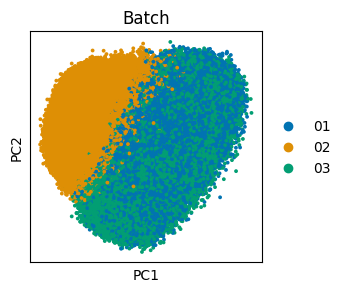

/home/icb/alessandro.palma/miniconda3/envs/IMPA_try/lib/python3.9/site-packages/anndata/_core/anndata.py:1292: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c
/home/icb/alessandro.palma/miniconda3/envs/IMPA_try/lib/python3.9/site-packages/anndata/_core/anndata.py:1292: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c
/home/icb/alessandro.palma/miniconda3/envs/IMPA_try/lib/python3.9/site-packages/anndata/_core/anndata.py:1292: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c
/home/icb/alessandro.palma/miniconda3/envs/IMPA_try/lib/python3.9/site-packages/anndata/_core/anndata.py:1292: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c
/home/icb/alessandro.palma/miniconda3/envs/IMPA_try/lib/python3.9/site-packages/anndata/_core/an

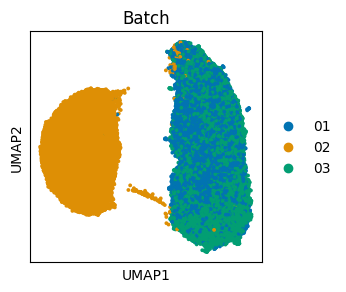

In [95]:
pca_umap_plot_with_preprocessing(adata_before_transf, "Batch", "batch")

After correction

In [96]:
adata_after_transf

AnnData object with n_obs × n_vars = 170943 × 384
    obs: 'batch', 'plate', 'well', 'view', 'no'

In [97]:
sc.tl.pca(adata_after_transf)
sc.pp.neighbors(adata_after_transf)
sc.tl.umap(adata_after_transf)

/home/icb/alessandro.palma/miniconda3/envs/IMPA_try/lib/python3.9/site-packages/anndata/_core/anndata.py:1292: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c
/home/icb/alessandro.palma/miniconda3/envs/IMPA_try/lib/python3.9/site-packages/anndata/_core/anndata.py:1292: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c
/home/icb/alessandro.palma/miniconda3/envs/IMPA_try/lib/python3.9/site-packages/anndata/_core/anndata.py:1292: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c
/home/icb/alessandro.palma/miniconda3/envs/IMPA_try/lib/python3.9/site-packages/anndata/_core/anndata.py:1292: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c
/home/icb/alessandro.palma/miniconda3/envs/IMPA_try/lib/python3.9/site-packages/anndata/_core/an

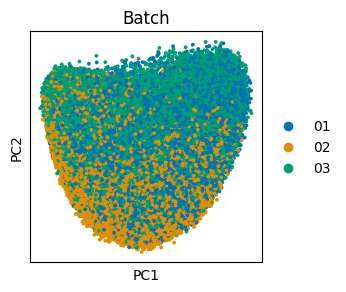

/home/icb/alessandro.palma/miniconda3/envs/IMPA_try/lib/python3.9/site-packages/anndata/_core/anndata.py:1292: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c
/home/icb/alessandro.palma/miniconda3/envs/IMPA_try/lib/python3.9/site-packages/anndata/_core/anndata.py:1292: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c
/home/icb/alessandro.palma/miniconda3/envs/IMPA_try/lib/python3.9/site-packages/anndata/_core/anndata.py:1292: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c
/home/icb/alessandro.palma/miniconda3/envs/IMPA_try/lib/python3.9/site-packages/anndata/_core/anndata.py:1292: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c
/home/icb/alessandro.palma/miniconda3/envs/IMPA_try/lib/python3.9/site-packages/anndata/_core/an

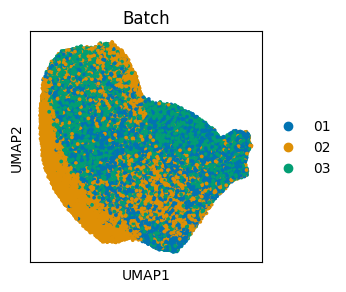

In [98]:
pca_umap_plot_with_preprocessing(adata_after_transf, "Batch", "batch")

## Save results

In [9]:
feature_dest_folder = Path("/home/icb/alessandro.palma/environment/IMPA/IMPA/project_folder/dino_featurization_project/featurized_anndata/rxrx1")

In [10]:
adata_after_transf = sc.read_h5ad(feature_dest_folder / "rxrx1_adata_after_transf.h5ad")

In [11]:
adata_before_transf = sc.read_h5ad(feature_dest_folder / "rxrx1_adata_before_transf.h5ad")

In [12]:
# adata_before_transf.write_h5ad(feature_dest_folder / "rxrx1_adata_before_transf.h5ad")

In [13]:
# adata_after_transf.write_h5ad(feature_dest_folder / "rxrx1_adata_after_transf.h5ad")

## Read scPoli

In [14]:
adata_scpoli = sc.read_h5ad(feature_dest_folder / "rxrx1_adata_scpoli.h5ad")

/home/icb/alessandro.palma/miniconda3/envs/IMPA_try/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


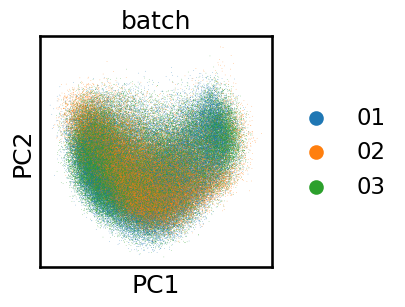

In [15]:
sc.pl.pca(adata_scpoli, color="batch")

## Read scGen

In [ ]:
adata_scgen = sc.read_h5ad(feature_dest_folder / "rxrx1_adata_scgen.h5ad")

In [ ]:
sc.pl.umap(adata_scgen, color="batch")

## Add compounds to anndata

In [16]:
data_index = pd.read_csv('/home/icb/alessandro.palma/environment/IMPA/IMPA/project_folder/datasets/rxrx1/metadata/rxrx1_df.csv', index_col=1)

In [17]:
compound_names = []

for row in adata_before_transf.obs.iterrows():
    batch = row[1].batch
    plate = row[1].plate
    well = row[1].well
    view = row[1]["view"]
    no = row[1].no
    file_name = f"U2OS-{batch}_{plate}_{well}_{view}_{no}"
    cpd = data_index.loc[file_name].CPD_NAME
    compound_names.append(cpd)

In [18]:
adata_before_transf.obs["compound"] = compound_names

In [19]:
adata_after_transf.obs["compound"] = compound_names

## Evaluate scib metrics

In [20]:
from scib_metrics.benchmark import Benchmarker
from scib_metrics.benchmark import BioConservation, BatchCorrection
import scib

In [21]:
adata_unique = adata_before_transf.copy()

In [22]:
biocons = BioConservation(isolated_labels=True, 
                              nmi_ari_cluster_labels_leiden=False, 
                              nmi_ari_cluster_labels_kmeans=False,
                              silhouette_label=False,
                              clisi_knn=False)
    
batch_correction = BatchCorrection(silhouette_batch=True,
                                    ilisi_knn=True, 
                                    kbet_per_label=True, 
                                    graph_connectivity=True, 
                                    pcr_comparison=False)

In [23]:
adata_unique.obsm["Unintegrated"] = adata_before_transf.obsm["X_pca"].copy()

In [24]:
adata_unique.obsm["IMPA-Integrated"] = adata_after_transf.obsm["X_pca"].copy()

In [25]:
adata_unique.obsm["scPoli-Integrated"] = adata_scpoli.X.copy()

In [27]:
# adata_unique.obsm["scGen-Integrated"] = adata_scgen.X.copy()

In [28]:
# adata_unique.obsm["harmony-Integrated"] = adata_before_transf.obsm['X_emb'].copy()

In [29]:
adata_before_transf

AnnData object with n_obs × n_vars = 170943 × 384
    obs: 'batch', 'plate', 'well', 'view', 'no', 'compound'
    uns: 'neighbors', 'pca', 'umap'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'connectivities', 'distances'

/home/icb/alessandro.palma/miniconda3/envs/IMPA_try/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


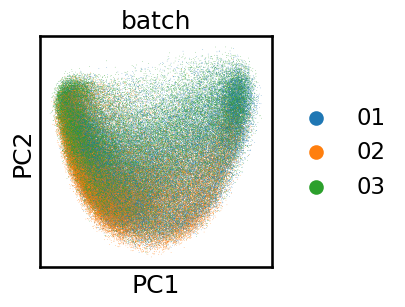

In [30]:
sc.pl.pca(adata_after_transf, color="batch")

In [31]:
from scib_metrics.benchmark import Benchmarker

In [33]:
bm = Benchmarker(
    adata_unique,
    batch_key="batch",
    label_key="compound",
    bio_conservation_metrics=biocons,
    batch_correction_metrics=batch_correction,
    embedding_obsm_keys=["Unintegrated", "IMPA-Integrated", "scPoli-Integrated"],
    n_jobs=6
)
bm.benchmark()

Metrics:   0%|          | 0/10 [00:00<?, ?it/s]
                                                                                             
Metrics:   0%|          | 0/10 [00:00<?, ?it/s]
                                                                                             
Embeddings: 100%|██████████| 3/3 [23:49<00:00, 476.66s/it]tch correction: graph_connectivity]

                                                                                             

In [ ]:
# scib_path = "/home/icb/alessandro.palma/environment/IMPA/IMPA/project_folder/dino_featurization_project/scib/rxrx1.pkl"

In [ ]:
# with open(scib_path, "wb") as file:
#     pkl.dump(bm, file)

In [ ]:
# with open(scib_path, "rb") as file:
#     b = pkl.load(file)

**Plot scib metrics**

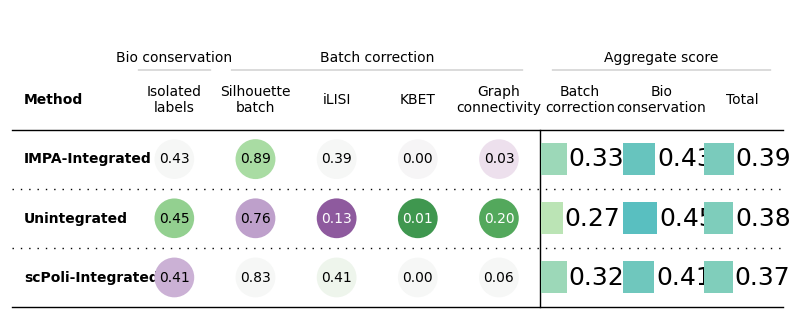

In [34]:
bm.plot_results_table(min_max_scale=False)

In [35]:
df = bm.get_results(min_max_scale=False)
df

,Isolated labels,Silhouette batch,iLISI,KBET,Graph connectivity,Batch correction,Bio conservation,Total
Embedding,,,,,,,,
Unintegrated,0.449383,0.759093,0.126182,0.010256,0.196414,0.272986,0.449383,0.378824
IMPA-Integrated,0.425507,0.891516,0.388609,0.0,0.029186,0.327328,0.425507,0.386235
scPoli-Integrated,0.407295,0.827731,0.411042,0.000156,0.058073,0.32425,0.407295,0.374077
Metric Type,Bio conservation,Batch correction,Batch correction,Batch correction,Batch correction,Aggregate score,Aggregate score,Aggregate score


/home/icb/alessandro.palma/miniconda3/envs/IMPA_try/lib/python3.9/site-packages/seaborn/rcmod.py:400: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(mpl.__version__) >= "3.0":
/home/icb/alessandro.palma/miniconda3/envs/IMPA_try/lib/python3.9/site-packages/setuptools/_distutils/version.py:345: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  other = LooseVersion(other)
/home/icb/alessandro.palma/miniconda3/envs/IMPA_try/lib/python3.9/site-packages/seaborn/palettes.py:443: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = mpl.cm.get_cmap(name)
/home/icb/alessandro.palma/miniconda3/envs/IMPA_try/lib/python3.9/site-packages/seaborn/categorical.py:381: DeprecationWarning: distutils Version classes are deprecat

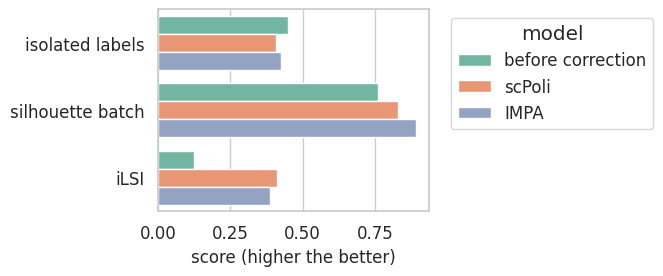

In [59]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# Data from the table
data = {
    'model': ['before correction', 'scPoli', 'IMPA'],
    'isolated labels': [0.449383, 0.407295, 0.425507],
    'silhouette batch': [0.759093, 0.827731, 0.891516],
    'iLSI': [0.126182, 0.411042, 0.388609]
    }

# Convert data to DataFrame
df = pd.DataFrame(data)

# Melt the DataFrame to plot with Seaborn
df_melted = pd.melt(df, id_vars=['model'], var_name='Metric', value_name='Score')

# Set aesthetic parameters
sns.set(style='whitegrid', font_scale=1.2)

# Plotting with Seaborn - Horizontal Point plot (Swarm plot)
plt.figure(figsize=(7, 3))
palette = sns.color_palette("Set2")  # Choose a suitable color palette
# sns.stripplot(data=df_melted, y='Metric', x='Score', hue='model', palette=palette, dodge=False, jitter=True, size=14)  # Increase size here
sns.barplot(data=df_melted, y='Metric', x='Score', hue='model', palette=palette)  # Increase size here
plt.title('', fontsize=12)
plt.xlabel('score (higher the better)', fontsize=12)
plt.ylabel('', fontsize=12)

plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

# Place legend outside the plot
plt.legend(title='model', fontsize=12, bbox_to_anchor=(1.05, 1), loc='upper left')

plt.tight_layout()  # Adjust layout to prevent clipping of labels
plt.savefig('/home/icb/alessandro.palma/environment/IMPA/IMPA/notebooks/cpg0000/plots/scib_metrics.svg',
           dpi=300, bbox_inches='tight', format='svg')
plt.show()

